In [1]:
import sys
sys.path.append("../../src")
sys.path.append("../../../../..")
import os
import numpy as np
import pickle
import scipy.io as sio
from example_reactiondiffusion import get_rd_data
from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

2025-05-29 11:07:55.209540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748531275.234868 2679547 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748531275.242683 2679547 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-29 11:07:55.271374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data_path = os.getcwd() + '/'
save_name = 'model_noisy'#'model1'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

In [3]:
_,_,test_data = get_rd_data()

## Single trajectory plots

In [4]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /trinity/home/andrew/repos/visde_dev/experiments/reaction_diffusion_2d/sindy_champion/examples/rd/model_noisy


I0000 00:00:1748531315.627270 2679547 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 957 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:82:00.0, compute capability: 8.9
I0000 00:00:1748531315.640032 2679547 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [5]:
z_sim = sindy_simulate(test_set_results['z'][0], test_data['t'][:,0],
                       params['coefficient_mask']*test_set_results['sindy_coefficients'],
                       params['poly_order'], params['include_sine'])

/tmp/ipykernel_2679547/2557834496.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(test_set_results['z'][:,0], 'k', color='#888888', linewidth=2)


(-49.95, 1048.95, -1.3125388383865357, 1.3280796766281129)

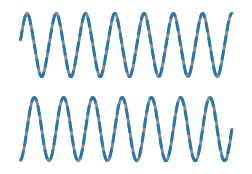

In [6]:
plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][:,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.subplot(2,1,2)
plt.plot(test_set_results['z'][:,1], color='#888888', linewidth=2)
plt.plot(z_sim[:,1], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

([], [])

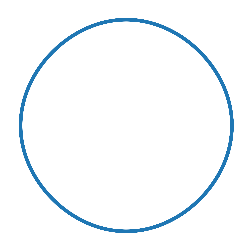

In [7]:
plt.figure(figsize=(3,3))
plt.plot(z_sim[:,0], z_sim[:,1], linewidth=2)
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

In [8]:
#decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
print(test_data['x'].shape)
decoder_x_error = np.sqrt(np.sum(np.power(test_data['x'] - test_set_results['x_decode'], 2), axis=1) / np.sum(np.power((test_data['x']), 2), axis=1))
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print(f'Decoder relative error: mean {np.mean(decoder_x_error)}, std dev {np.std(decoder_x_error)}')
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy relative error, z: %f' % sindy_dz_error)

(1000, 10000)
Decoder relative error: mean 0.1303027783150559, std dev 0.008262574381100446
Decoder relative SINDy error: 0.016778
SINDy relative error, z: 0.002063
